In [76]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd

from sentence_transformers import SentenceTransformer
from scipy.stats import multinomial

import matplotlib.pyplot as plt
import collections

# Sentence-BERT model

In [ ]:
df = pd.read_csv('../data/interim/testset2.csv')
model = SentenceTransformer('all-mpnet-base-v2', device='cuda:0')

sentences = [f'A photo of a {word}' for word in df.word0.values]
embeddings0 = model.encode(sentences)

sentences = [f'A photo of a {word}' for word in df.word1.values]
embeddings1 = model.encode(sentences)

sentences = [f'A photo of a {word}' for word in df.word2.values]
embeddings2 = model.encode(sentences)

sim2 = (embeddings0 * embeddings1).sum(axis=1)
sim1 = (embeddings0 * embeddings2).sum(axis=1)
sim0 = (embeddings1 * embeddings2).sum(axis=1)

odd_one_out = np.stack([sim0, sim1, sim2], axis=1).argmax(axis=1)
odd_one_out

(df['best_answer'] == odd_one_out).mean()

# GPT3.5 model

In [3]:
method = 'chain'

vals = []
for order in range(3):
    df = pd.read_csv(f'../results/testset2_chat_gpt-3.5-turbo_{method}_{order}.csv')
    vals.append(df['gpt-3.5-turbo'].values)


majorities = []
for ans in zip(*vals):
    # Count the most frquent answer
    ans = np.array(ans)
    # If no majority vote, then choose the most frequent answer
    majority = -1
    for i in range(3):
        if (ans == i).sum() >= 2:
            # Majority vote
            majority = i
            break
    majorities.append(majority)

df['majority'] = majorities

selected = df['majority'] != -1

print((df['majority'] == -1).mean())
print((df['majority'] == df['best_answer'])[selected].mean())
print((df['majority'] == df['best_answer']).mean())

0.103
0.620958751393534
0.557


# GPT-4

In [41]:
methods = ['direct', 'chain', 'pairs', 'rubric', 'visual']
method = methods[1]
model = 'gpt-4'

dataset = f'../results/testset2_chat_{model}_{method}_0.csv'
print(dataset)
df = pd.read_csv(dataset)
val0 = df[model]

print(val0.value_counts())
(df['best_answer'] == val0).mean()

../results/testset2_chat_gpt-4_chain_0.csv
1    396
0    371
2    233
Name: gpt-4, dtype: int64


0.636

## Examine some of the differences

In [17]:
A = np.stack([df.im0_chosen.values, 
              df.im1_chosen.values, 
              df.im2_chosen.values], axis=1)
the_max = np.max(A, axis=1)
the_sum = np.sum(A, axis=1)
non_controversy = (the_max / the_sum) > .75
the_max.shape
df[(df['best_answer'] != val0) & non_controversy].head(15)

,Unnamed: 0,c0,c1,c2,im0_chosen,im1_chosen,im2_chosen,word0,word1,word2,best_answer,gpt-4,gpt-4_reasoning
39,39,25295,18829,8506,3,30,5,anchor,banana peel,recorder,1,0,"1. Anchor: heavy, metal, used for holding boat..."
74,74,22925,21341,4184,34,0,4,ashtray,easter egg,goldfish,0,2,Step 1: Identify similarities and differences ...
87,87,14950,17107,27925,0,37,2,badge,green beans,hearse,1,0,Step 1: Compare objects 1 and 2 (badge and gre...
104,104,35746,33487,2815,37,1,0,banana,crow,scorpion,0,1,Step 1: Compare the objects in pairs\n- 1 (ban...
116,116,16930,16110,9494,6,26,2,barcode,cart,laptop,1,0,Step 1: Comparing object 1 (barcode) with obje...
117,117,12356,12138,47606,1,0,34,barcode,filter,seal,2,0,Step 1: Analyze the objects and their purpose....
120,120,29966,40230,37326,4,33,0,bark,parrot,tree,1,0,Step 1: Identify the properties of each object...
125,125,24314,29128,12323,27,2,6,barrel,blinder,tiger,0,2,Step 1: Analyze the three objects:\n1: barrel ...
148,148,47706,43611,10026,30,6,1,baton,leopard,tumbleweed,0,1,Step 1: Identify the key features of each obje...
191,191,30938,35452,6258,33,2,1,bell pepper,curling iron,shower curtain,0,1,Step 1: Identify the characteristics of each o...


# GPT-4 calibration

In [68]:
methods = ['direct', 'chain', 'pairs', 'rubric', 'visual']
method = methods[1]
model = 'gpt-4'

vals = []
for order in range(12):
    dataset = f'../results/testset2_chat_{model}_{method}_{order}.csv'
    df = pd.read_csv(dataset)
    df = df.loc[:100]

    vals.append(df[model].values)

V = np.stack(vals, axis=1)

In [69]:
# Calculate the most frequent value along the second axis
most_frequent = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, V)

(most_frequent == df.best_answer).mean()

0.7425742574257426

In [72]:
# Calculate the most frequent value along the second axis, sampling between 1 and 6 columns
scores = collections.defaultdict(list)
for num in range(2 ** 12):
    mask = np.zeros(12, dtype=bool)
    for i in range(12):
        is_good = (num >> (11 - i)) & 1
        if is_good:
            mask[i] = True

    if all(mask == False):
        continue

    most_frequent = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, V[:, mask])
    scores[mask.sum()].append((most_frequent == df.best_answer).mean())


x = []
y = []
s = []
for k, v in scores.items():
    x.append(k)
    y.append(np.mean(v))
    s.append(np.std(v))

x = np.array(x)
y = np.array(y)
s = np.array(s)

Text(0.5, 1.0, 'GPT-4 scaling with number of samples')

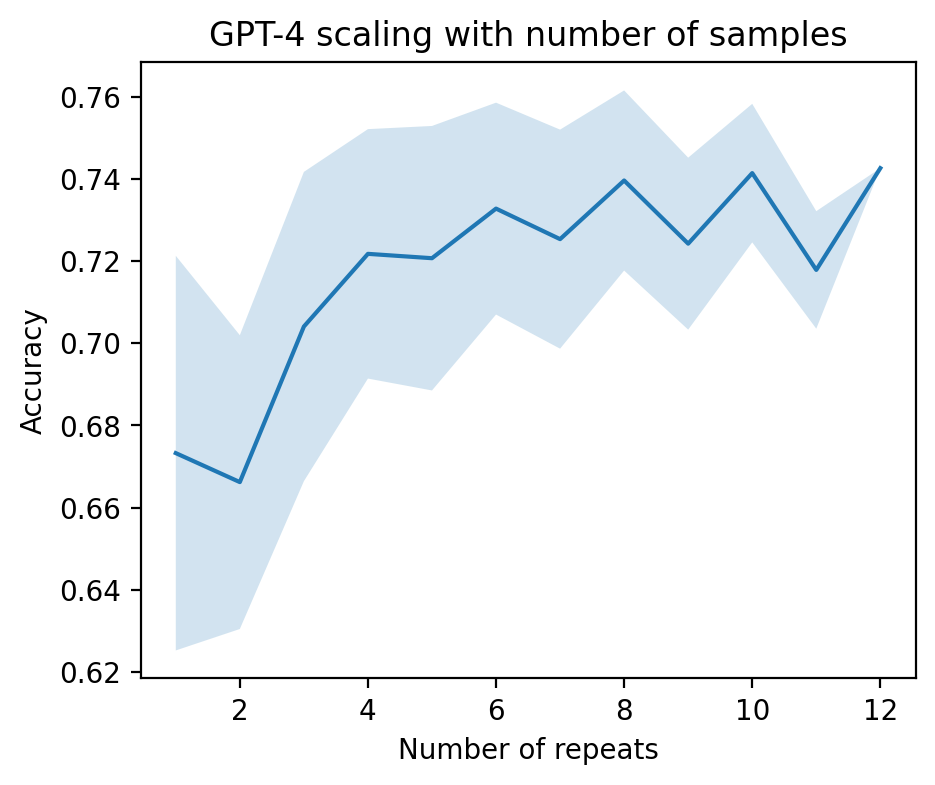

In [86]:
plt.figure(figsize=(5, 4))
plt.fill_between(x, y + s, y - s, alpha=.2)
plt.plot(x, y)
plt.xlabel('Number of repeats')
plt.ylabel('Accuracy')
plt.box('off')
plt.title('GPT-4 scaling with number of samples')

## Estimate oracle score

Method 1: estimate the sampling noise using a multinomial model.

In [5]:
# Evaluate best possible answer combo.
nboot = 100
P = df[['im0_chosen', 'im1_chosen', 'im2_chosen']].values
N_total = P.sum(axis=1)
P = P / P.sum(axis=1, keepdims=True)

samples = []
for i in range(1000):
    samples.append(np.argmax(multinomial.rvs(N_total[i], P[i, :], size=100), axis=1))
the_ceil = (df.best_answer.values.reshape((-1, 1)) == np.array(samples)).mean(axis=0)
print(the_ceil.mean(), the_ceil.std())

0.9253000000000003 0.005577633906953741


Method 2: estimate the sampling noise by looking at the repeats of the same set.

In [19]:
df0 = pd.read_csv('../data/interim/testset2.csv')
df1 = pd.read_csv('../data/interim/testset2_repeat.csv')

(df0.best_answer == df1.best_answer).mean()

0.94